In [12]:
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/hemispace' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import hemispace_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
data_dir = params.data_dir
results_dir = params.results_dir
fig_dir = params.fig_dir

sub_info = params.sub_info
task_info = params.task_info

suf = params.suf
rois = params.rois
hemis = params.hemis



#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')


#mni = load_mni152_brain_mask()

In [4]:
#load data summary
analysis_type = 'selectivity'
data_summary = pd.read_csv(f'{results_dir}/{analysis_type}/{analysis_type}_summary{suf}.csv')

In [11]:
'''
Calculate t-test between hemis for controls
'''
conds = ['word', 'face','tool','space']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex']
analysis_type = 'selectivity'

#load data summary
data_summary = pd.read_csv(f'{results_dir}/{analysis_type}/{analysis_type}_summary{suf}.csv')

#extract controls
data_summary = data_summary[data_summary['group']=='control']

#loop through conds
for cond, roi in zip(conds, rois):
    #exract data for cond and roi
    curr_data = data_summary[(data_summary['cond']==cond) & (data_summary['roi']==roi)]

    #convert data to wide by subject
    curr_data = curr_data.pivot(index='sub', columns='hemi', values='sum_selec_norm')
    
    #run paired t-test between hemis
    t, p = stats.ttest_rel(curr_data['left'], curr_data['right'])

    #calculate effect size
    d = (curr_data['left'].mean() - curr_data['right'].mean()) / (np.sqrt((curr_data['left'].std() ** 2 + curr_data['right'].std() ** 2) / 2))


    print(cond, t, curr_data.shape[0]-1, p, d)


word 6.177456729107944 20 4.916417865230383e-06 1.3433854094708415
face -4.453222484268767 20 0.00024397064645004447 -0.7424827915443565
tool 3.18548159948312 23 0.00411903394604695 0.4146833357011268
space -5.826643523364782 23 6.155771996654816e-06 -0.4511477450063069


In [14]:
def create_violin(resample_data,data_mean, indiv_data,  analysis, analysis_name, roi, cond):
    seed = 2
    p = ggplot(resample_data, aes(x = 'group', y = analysis, fill = 'hemi'))  + \
                geom_violin( alpha = .3, position =  position_dodge(.9) ) + \
                geom_jitter(indiv_data,aes(x = 'group', y = analysis, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed)) + \
                geom_linerange(data_mean, aes(x = 'group', ymin = f'{analysis} - se', ymax = f'{analysis} + se', fill = 'hemi'), size = 1,position = position_dodge(.9)) + \
                geom_point(data_mean, aes(x = 'group', y = analysis, fill = 'hemi'), shape = 's', size = 3,position = position_dodge(.9)) + \
                geom_label(indiv_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \
                scale_fill_manual(values = ['#ee7183', '#7398af']) + \
                xlab('Group') + ylab(analysis_name) + \
                theme_classic() + \
                theme(text = element_text(color ='black'), 
                    axis_text_x= element_text(angle = 30, size = 12),
                    axis_text_y= element_text(size = 12),
                    axis_title=element_text(size = 14),
                    axis_line=element_line(), 
                    legend_position = 'none',
                    panel_border=element_blank(),
                    figure_size = (3, 5))+ \
                    labs(fill='Hemisphere') #+ ggtitle(f'{cond}')

    p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)
    print(p)

sum_selec_norm word ventral_visual_cortex


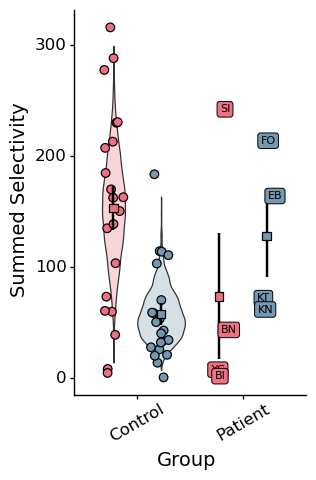


sum_selec_norm face ventral_visual_cortex


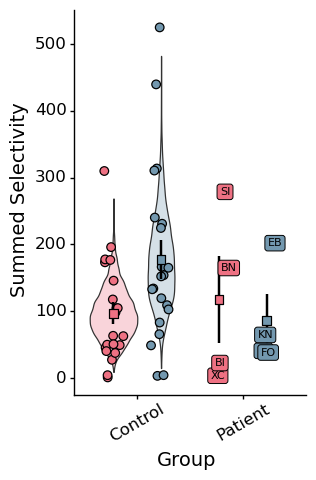


sum_selec_norm tool dorsal_visual_cortex


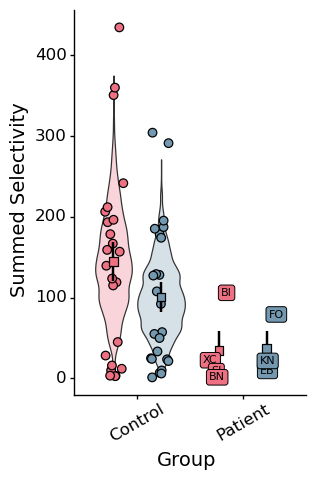


sum_selec_norm space dorsal_visual_cortex


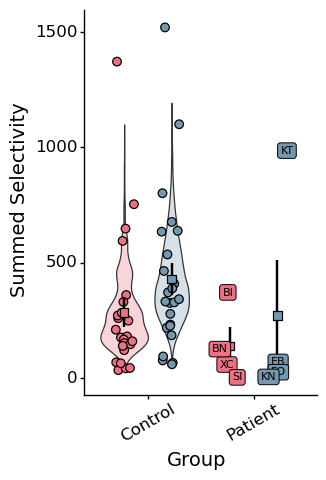


sum_selec_norm word hemi


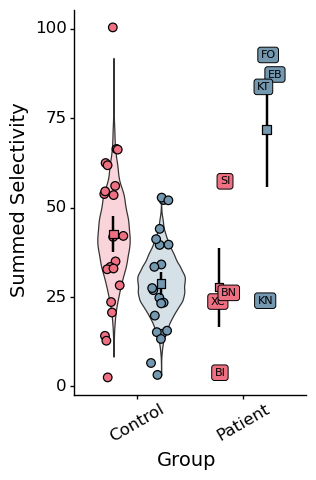


sum_selec_norm face hemi


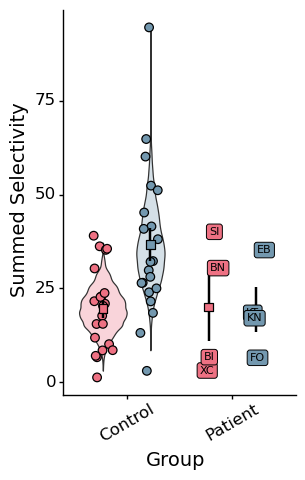


sum_selec_norm tool hemi


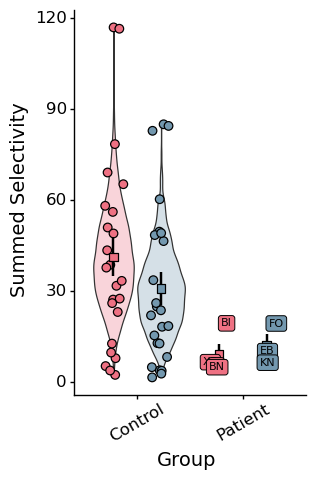


sum_selec_norm space hemi


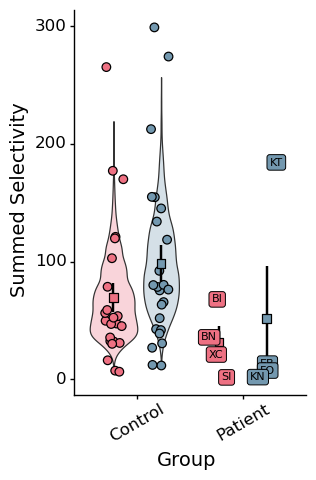

In [15]:
'''
Create selectivity plots
'''

analysis_type = 'selectivity'

#load data summary
data_summary = pd.read_csv(f'{results_dir}/{analysis_type}/{analysis_type}_summary{suf}.csv')
#capitalize hemi
data_summary['hemi'] = data_summary['hemi'].str.capitalize()

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code



analyses = ['sum_selec_norm', 'mean_act','volume']
analysis_names = ['Summed Selectivity', 'Mean Activation', 'Active Volume mm\u00b3']
analyses = ['sum_selec_norm']

conds = ['word', 'face','tool','space','word', 'face','tool','space','word', 'face','tool','space']
conds = ['word', 'face','tool','space','word', 'face','tool','space']

#rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex',
        'hemi','hemi','hemi','hemi', 'hemi','hemi' ]


for analysis, analysis_name in zip(analyses,analysis_names):

        
    act_resamples = pd.read_csv(f'{results_dir}/{analysis_type}/resamples/{analysis}_resamples{suf}.csv')

    #replace columns with dorsal visual cortex with dvc
    for col in act_resamples.columns:
        if 'dorsal_visual_cortex' in col:
            new_col = col.replace('dorsal_visual_cortex','dvc')
            act_resamples.rename(columns={col:new_col}, inplace=True)
        if 'ventral_visual_cortex' in col:
            new_col = col.replace('ventral_visual_cortex','vvc')
            act_resamples.rename(columns={col:new_col}, inplace=True)



    #convert act resamples to long format
    act_resamples_long = pd.melt(act_resamples, var_name='type', value_name=analysis)

    #split type column in cond, hemi, roi
    act_resamples_long[['cond','hemi','roi']] = act_resamples_long['type'].str.split('_',expand=True)

    #rename roi column
    act_resamples_long['roi'].replace('dvc','dorsal_visual_cortex',inplace=True)
    act_resamples_long['roi'].replace('vvc','ventral_visual_cortex',inplace=True)

    #capitalize hemi
    act_resamples_long['hemi'] = act_resamples_long['hemi'].str.capitalize()
    act_resamples_long['group'] = 'Control'
    
    for cond, roi in zip(conds, rois):
        print(analysis, cond, roi)

        resample_data = act_resamples_long[(act_resamples_long['cond']==cond) & (act_resamples_long['roi']==roi)]
        curr_summary = data_summary[(data_summary['cond']==cond) & (data_summary['roi']==roi)]
        curr_summary['group'] = curr_summary['group'].str.capitalize()

        #create mean and SE data for patients
        data_mean = curr_summary.groupby(['hemi', 'group']).mean().reset_index()
        data_mean_se = curr_summary.groupby(['hemi', 'group']).sem().reset_index()
        data_mean['se'] = data_mean_se[analysis]
        data_mean['group'] = data_mean['group'].str.capitalize()

        create_violin(resample_data,data_mean, curr_summary,  analysis, analysis_name, roi, cond)
    

In [6]:
resample_data = act_resamples_long[(act_resamples_long['cond']==cond) & (act_resamples_long['roi']==roi)]

In [8]:
cond, roi

('word', 'hemi')

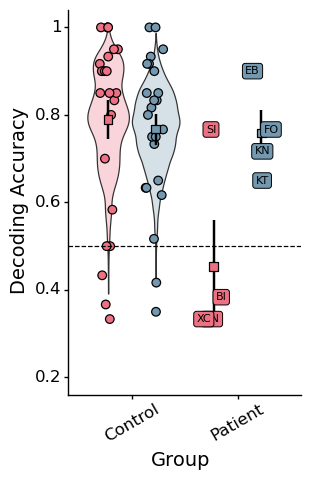

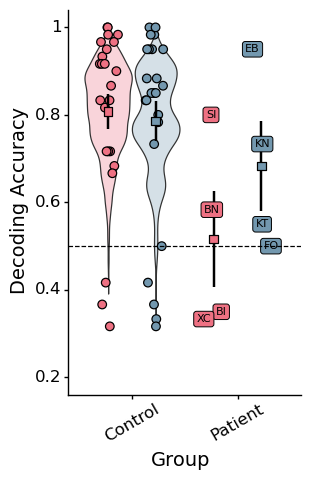

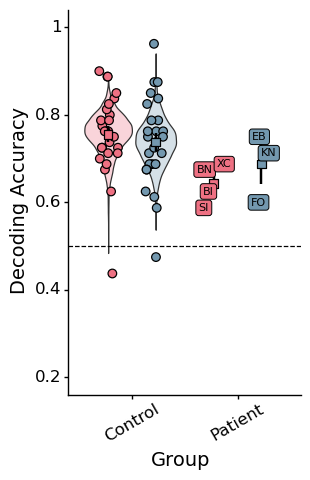

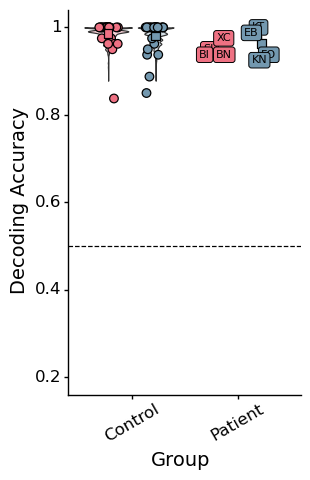

In [9]:
'''
Create decoding plots
'''

analysis_type = 'decoding'

#load data summary
data_summary = pd.read_csv(f'{results_dir}/{analysis_type}/{analysis_type}_summary{suf}.csv')
#capitalize hemi
data_summary['hemi'] = data_summary['hemi'].str.capitalize()

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code



analyses = ['acc']
analysis_names = ['Decoding Accuracy']

conds = ['word', 'face','tool','space']

#rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex']
#rois = ['hemi', 'hemi', 'hemi','hemi']

for analysis, analysis_name in zip(analyses,analysis_names):

        
    act_resamples = pd.read_csv(f'{results_dir}/{analysis_type}/resamples/{analysis}_resamples{suf}.csv')

    #replace columns with dorsal visual cortex with dvc
    for col in act_resamples.columns:
        if 'dorsal_visual_cortex' in col:
            new_col = col.replace('dorsal_visual_cortex','dvc')
            act_resamples.rename(columns={col:new_col}, inplace=True)
        if 'ventral_visual_cortex' in col:
            new_col = col.replace('ventral_visual_cortex','vvc')
            act_resamples.rename(columns={col:new_col}, inplace=True)



    #convert act resamples to long format
    act_resamples_long = pd.melt(act_resamples, var_name='type', value_name=analysis)

    #split type column in cond, hemi, roi
    act_resamples_long[['cond','hemi','roi']] = act_resamples_long['type'].str.split('_',expand=True)

    #rename roi column
    act_resamples_long['roi'].replace('dvc','dorsal_visual_cortex',inplace=True)
    act_resamples_long['roi'].replace('vvc','ventral_visual_cortex',inplace=True)

    #capitalize hemi
    act_resamples_long['hemi'] = act_resamples_long['hemi'].str.capitalize()
    act_resamples_long['group'] = 'Control'
    
    for cond, roi in zip(conds, rois):
        resample_data = act_resamples_long[(act_resamples_long['cond']==cond) & (act_resamples_long['roi']==roi)]
        curr_summary = data_summary[(data_summary['cond']==cond) & (data_summary['roi']==roi)]
        curr_summary['group'] = curr_summary['group'].str.capitalize()

        #create mean and SE data for patients
        data_mean = curr_summary.groupby(['hemi', 'group']).mean().reset_index()
        data_mean_se = curr_summary.groupby(['hemi', 'group']).sem().reset_index()
        data_mean['se'] = data_mean_se[analysis]
        data_mean['group'] = data_mean['group'].str.capitalize()

        seed = 2
        p = ggplot(resample_data, aes(x = 'group', y = analysis, fill = 'hemi'))  + \
                    geom_violin( alpha = .3, position =  position_dodge(.9) ) + \
                    geom_jitter(curr_summary,aes(x = 'group', y = analysis, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed)) + \
                    geom_linerange(data_mean, aes(x = 'group', ymin = f'{analysis} - se', ymax = f'{analysis} + se', fill = 'hemi'), size = 1,position = position_dodge(.9)) + \
                    geom_point(data_mean, aes(x = 'group', y = analysis, fill = 'hemi'), shape = 's', size = 3,position = position_dodge(.9)) + \
                    geom_label(curr_summary, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \
                    scale_fill_manual(values = ['#ee7183', '#7398af']) + \
                    xlab('Group') + ylab(analysis_name) + \
                    ylim(.2,1) + theme_classic() + \
                    theme(text = element_text(color ='black'), 
                        axis_text_x= element_text(angle = 30, size = 12),
                        axis_text_y= element_text(size = 12),
                        axis_title=element_text(size = 14),
                        axis_line=element_line(), 
                        legend_position = 'none',
                        panel_border=element_blank(),
                        figure_size = (3, 5))+ \
                        labs(fill='Hemisphere') + geom_hline(yintercept = 0.5, linetype = 'dashed', color = 'black')
        

        print(p)
        p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)
        
        

In [ ]:
'''
Create Decoding plots
'''

#load data summary
data_summary = pd.read_csv(f'{results_dir}/hemispace_decoding{suf}.csv')

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code


analyses = ['acc', 'mean_act','volume']
analysis_names = ['Decoding Accuracy %']
conds = ['space','tool','face','word']

rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']

for analysis, analysis_name in zip(analyses,analysis_names):
    for cond, roi in zip(conds, rois):
        curr_data = data_summary[(data_summary['cond'] == cond) & (data_summary['roi'] ==roi)]
        #capitalize hemi amd group
        curr_data['hemi'] = curr_data['hemi'].str.capitalize()
        curr_data['group'] = curr_data['group'].str.capitalize()


        mean_data = curr_data.groupby(by = ['group', 'hemi']).mean().reset_index()
        temp_se  = curr_data.groupby(by = ['group', 'hemi']).sem().reset_index()
        mean_data['se'] = temp_se[analysis]

        seed = 2
        #plot grouped bar plot with plotnine
        p = ggplot(mean_data, aes(x = 'group', y = analysis, fill = 'hemi'))  + \
                    geom_col(stat = 'identity', color = 'black', position = 'dodge') + \
                    geom_linerange(aes(x='group', ymin = f'{analysis} - se', ymax = f'{analysis} + se'), position = position_dodge(width = .9)) +\
                    geom_jitter(curr_data,aes(x = 'group', y = analysis, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.3, random_state = seed)) + \
                    scale_fill_manual(values = ['#ee7183', '#7398af']) + \
                    theme_classic() + geom_hline(yintercept =.5, linetype ='dashed') + \
                    geom_label(curr_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=1, jitter_width = 0.3, random_state = seed),  size = 8) + \
                    xlab('Group') + ylab(analysis_name) + \
                    theme(text = element_text(color ='black'), 
                        axis_text_x= element_text(angle = 30, size = 12),
                        axis_text_y= element_text(size = 12),
                        axis_title=element_text(size = 14),
                        axis_line=element_line(), 
                        legend_position = 'none',
                        panel_border=element_blank(),
                        figure_size = (3, 5))+ \
                        labs(fill='Hemisphere') + ggtitle(cond.capitalize())

                    

        print(p)
        p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)
        
                    


In [5]:
def create_bar(mean_data, curr_data, analysis, analysis_name, roi, cond):
    seed = 2
    #plot grouped bar plot with plotnine
    p = ggplot(mean_data, aes(x = 'group', y = analysis, fill = 'hemi'))  + \
                geom_col(stat = 'identity', color = 'black', position = 'dodge') + \
                geom_linerange(aes(x='group', ymin = f'{analysis} - se', ymax = f'{analysis} + se'), position = position_dodge(width = .9)) +\
                geom_jitter(curr_data,aes(x = 'group', y = analysis, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.3, random_state = seed)) + \
                scale_fill_manual(values = ['#ee7183', '#7398af']) + \
                geom_label(curr_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=1, jitter_width = 0.3, random_state = seed),  size = 8) + \
                xlab('Group') + ylab(analysis_name) + \
                theme_classic() + \
                theme(text = element_text(color ='black'), 
                    axis_text_x= element_text(angle = 30, size = 12),
                    axis_text_y= element_text(size = 12),
                    axis_title=element_text(size = 14),
                    axis_line=element_line(), 
                    legend_position = 'none',
                    panel_border=element_blank(),
                    figure_size = (3, 5))+ \
                    labs(fill='Hemisphere') + ggtitle(cond.capitalize())

                

    print(p)
    p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)

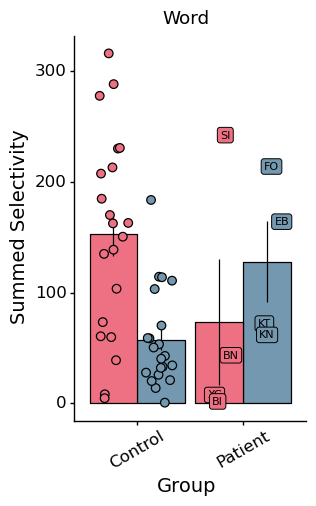

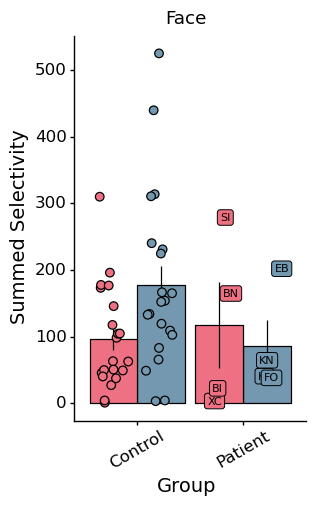

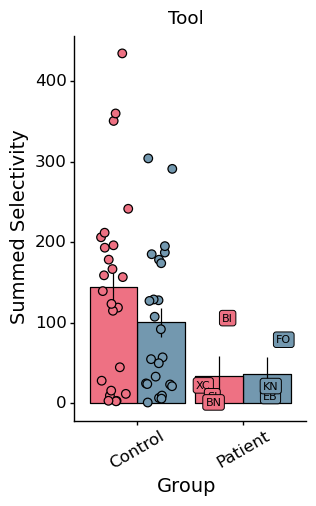

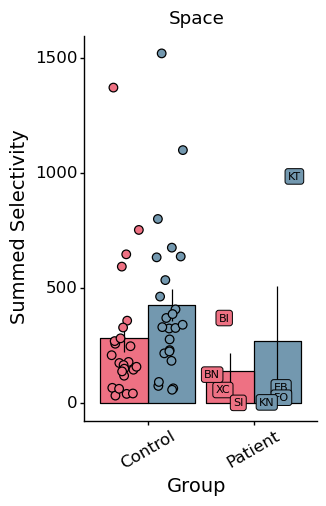

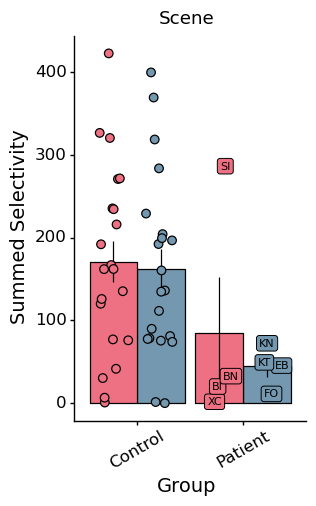

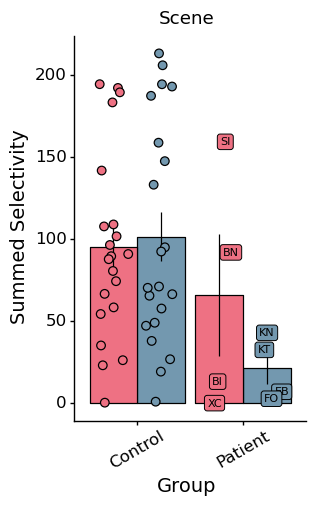

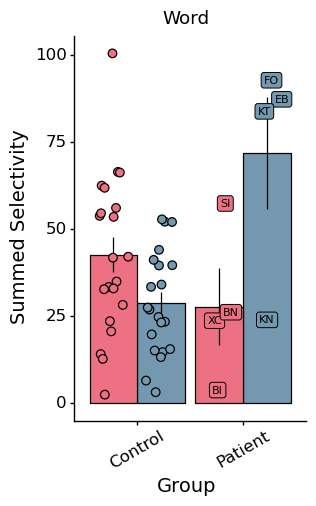

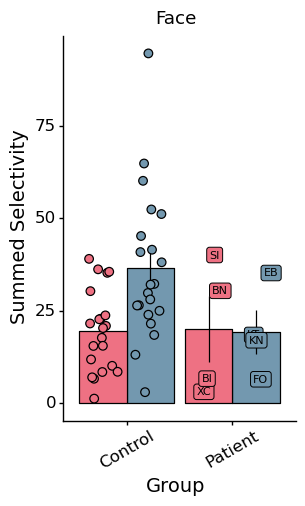

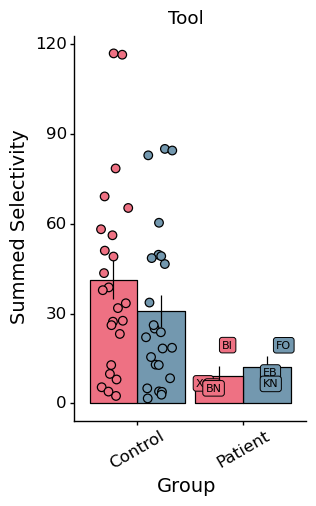

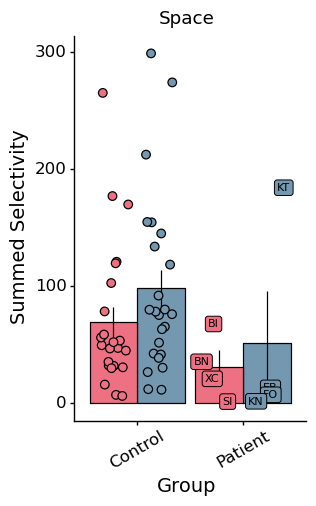

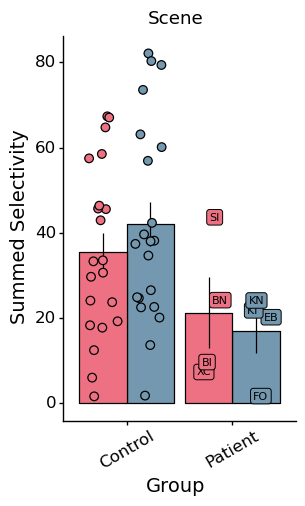

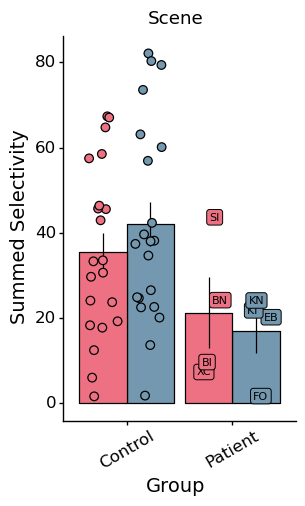

In [8]:
#load data summary
data_summary = pd.read_csv(f'{results_dir}/selectivity/selectivity_summary{suf}.csv')

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code


analyses = ['sum_selec_norm', 'mean_act','volume']
analysis_names = ['Summed Selectivity', 'Mean Activation', 'Active Volume mm\u00b3']
conds = ['space','tool','face','word']

analyses = ['sum_selec_norm']
analysis_names = ['Summed Selectivity']


rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']
#rois = ['hemi', 'hemi', 'hemi','hemi']

conds = ['word', 'face','tool','space','scene','scene','word', 'face','tool','space','scene','scene']

#rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex', 'ventral_visual_cortex','dorsal_visual_cortex',
        'hemi','hemi','hemi','hemi', 'hemi','hemi' ]


for analysis, analysis_name in zip(analyses,analysis_names):
    for cond, roi in zip(conds, rois):
        curr_data = data_summary[(data_summary['cond'] == cond) & (data_summary['roi'] ==roi)]
        #capitalize hemi amd group
        curr_data['hemi'] = curr_data['hemi'].str.capitalize()
        curr_data['group'] = curr_data['group'].str.capitalize()


        mean_data = curr_data.groupby(by = ['group', 'hemi']).mean().reset_index()
        temp_se  = curr_data.groupby(by = ['group', 'hemi']).sem().reset_index()
        mean_data['se'] = temp_se[analysis]

        create_bar(mean_data, curr_data, analysis, analysis_name, roi, cond)
        
                    


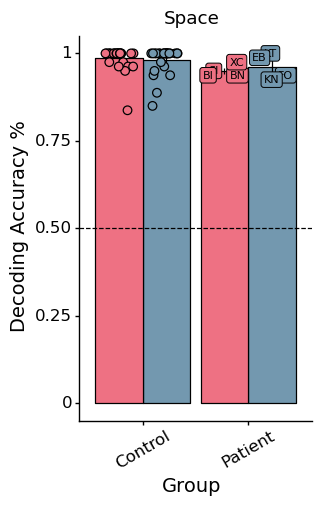

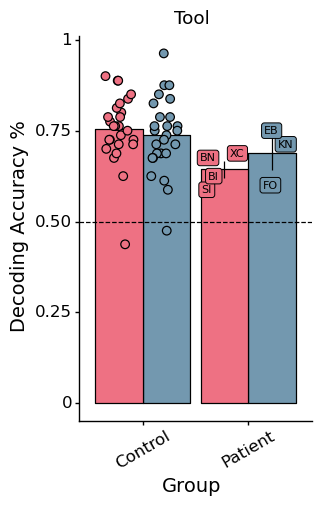

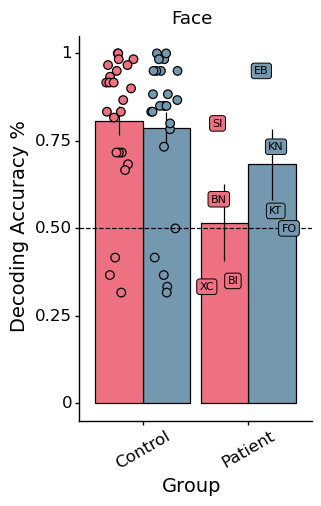

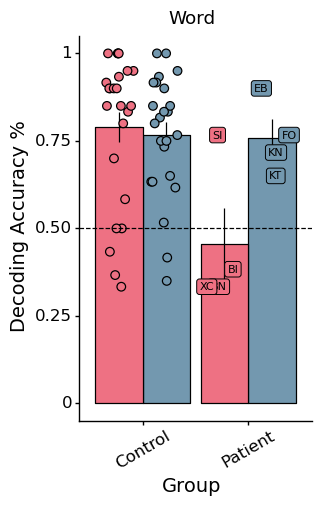

In [18]:
'''
Create Decoding plots
'''

#load data summary
data_summary = pd.read_csv(f'{results_dir}/hemispace_decoding{suf}.csv')

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code


analyses = ['acc', 'mean_act','volume']
analysis_names = ['Decoding Accuracy %']
conds = ['space','tool','face','word']

rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']

conds = ['word', 'face','tool','space','scene','scene','word', 'face','tool','space','scene','scene']

#rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex', 'ventral_visual_cortex','dorsal_visual_cortex',
        'hemi','hemi','hemi','hemi', 'hemi','hemi' ]


for analysis, analysis_name in zip(analyses,analysis_names):
    for cond, roi in zip(conds, rois):
        curr_data = data_summary[(data_summary['cond'] == cond) & (data_summary['roi'] ==roi)]
        #capitalize hemi amd group
        curr_data['hemi'] = curr_data['hemi'].str.capitalize()
        curr_data['group'] = curr_data['group'].str.capitalize()


        mean_data = curr_data.groupby(by = ['group', 'hemi']).mean().reset_index()
        temp_se  = curr_data.groupby(by = ['group', 'hemi']).sem().reset_index()
        mean_data['se'] = temp_se[analysis]

        seed = 2
        #plot grouped bar plot with plotnine
        p = ggplot(mean_data, aes(x = 'group', y = analysis, fill = 'hemi'))  + \
                    geom_col(stat = 'identity', color = 'black', position = 'dodge') + \
                    geom_linerange(aes(x='group', ymin = f'{analysis} - se', ymax = f'{analysis} + se'), position = position_dodge(width = .9)) +\
                    geom_jitter(curr_data,aes(x = 'group', y = analysis, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.3, random_state = seed)) + \
                    scale_fill_manual(values = ['#ee7183', '#7398af']) + \
                    theme_classic() + geom_hline(yintercept =.5, linetype ='dashed') + \
                    geom_label(curr_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=1, jitter_width = 0.3, random_state = seed),  size = 8) + \
                    xlab('Group') + ylab(analysis_name) + \
                    theme(text = element_text(color ='black'), 
                        axis_text_x= element_text(angle = 30, size = 12),
                        axis_text_y= element_text(size = 12),
                        axis_title=element_text(size = 14),
                        axis_line=element_line(), 
                        legend_position = 'none',
                        panel_border=element_blank(),
                        figure_size = (3, 5))+ \
                        labs(fill='Hemisphere') + ggtitle(cond.capitalize())

                    

        print(p)
        p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)
        
                    


In [3]:
def create_histplot(boot_data, sub_data, group,metric, title, save=True):
    bin_range = [np.min(boot_data)-np.std(boot_data), np.max(boot_data)+np.std(boot_data)]
    sns.histplot(boot_data, binrange = bin_range)
    #add x axis label
    plt.xlabel(metric)
    
    for sub, val in zip(sub_data['sub'], sub_data[metric]):
        
        
        #add a line for each patient
        plt.axvline(val, color = 'red')
        rand_int = np.random.randint(100,500)

        #for patients add their code
        if group == 'patient':
            #find code corresponding to sub
            sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
            #add text for each patient
            plt.text(val+(np.std(boot_data)/3), rand_int, sub_code, color = 'red')

    #add title
    plt.title(title)

    #if save is true, save figure
    if save:
        file_name = title.replace(' ','_')
        file_name = f'{metric}_{file_name}{suf}'
        plt.savefig(f'{fig_dir}/hist/indiv/{file_name}.png')
    
    #random number between 100 and 500
   


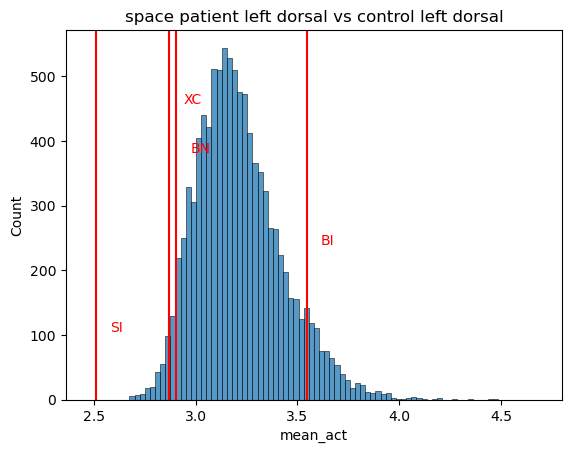

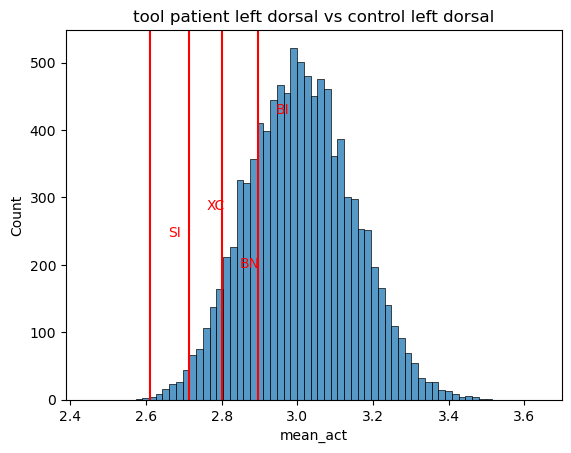

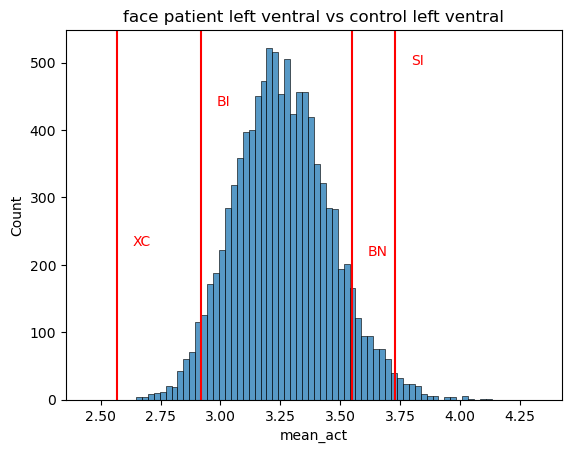

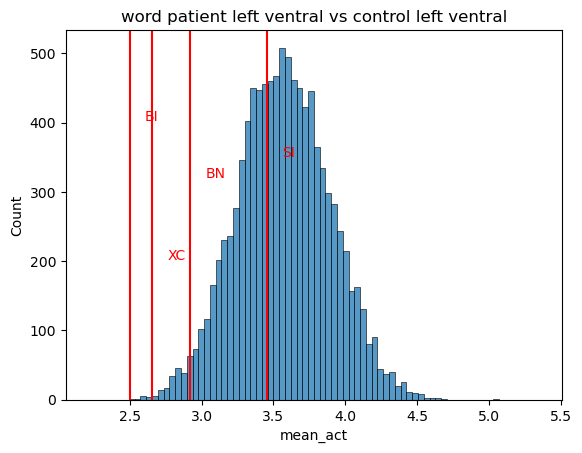

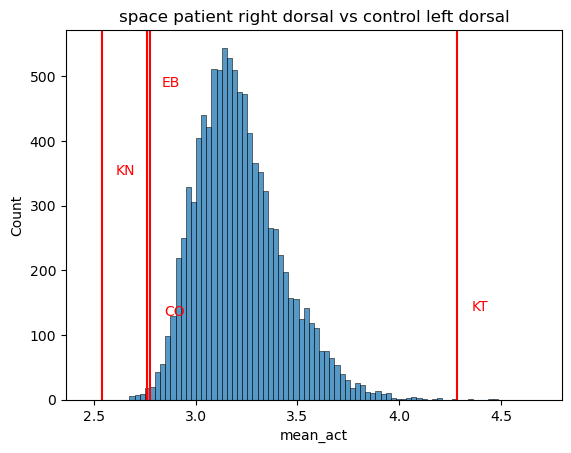

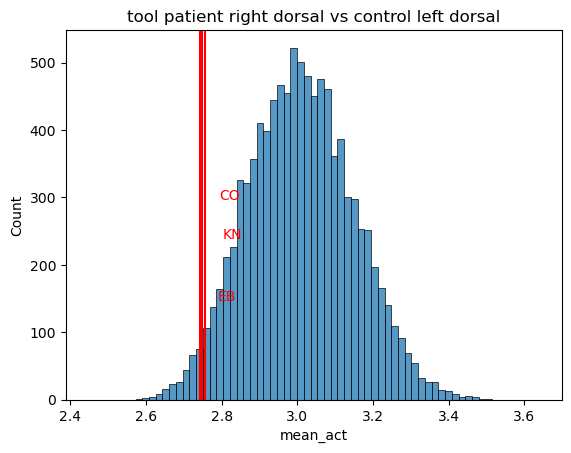

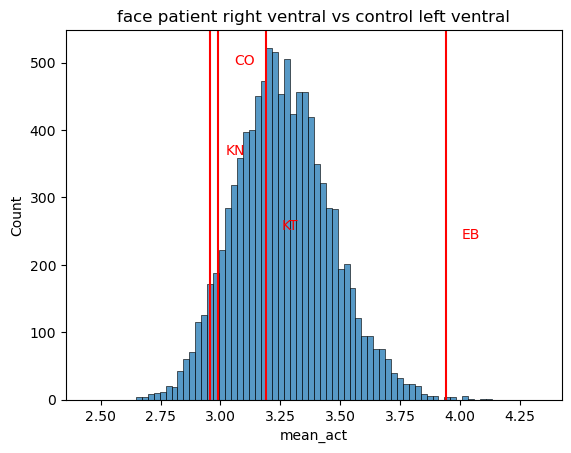

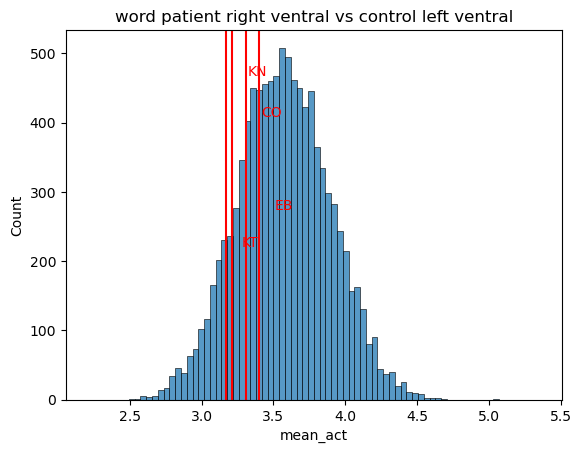

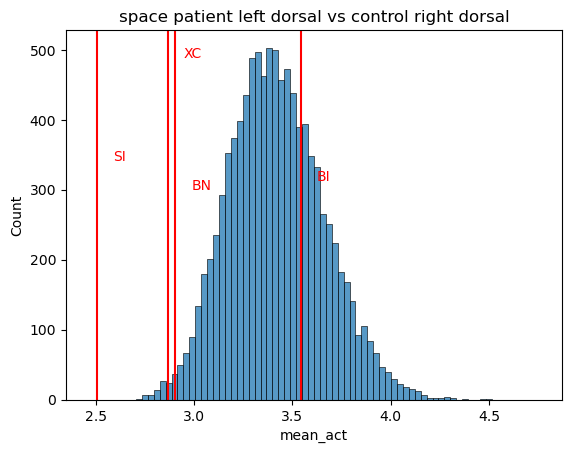

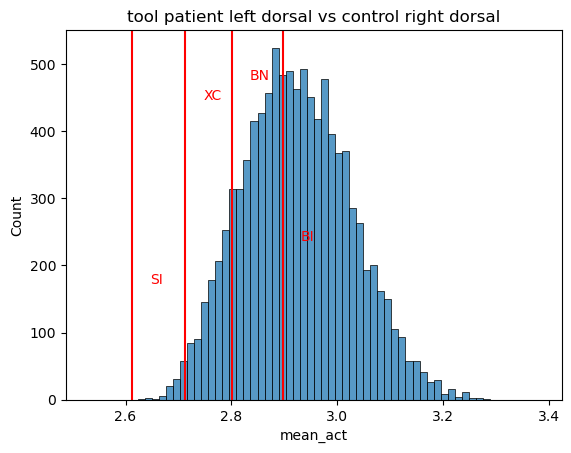

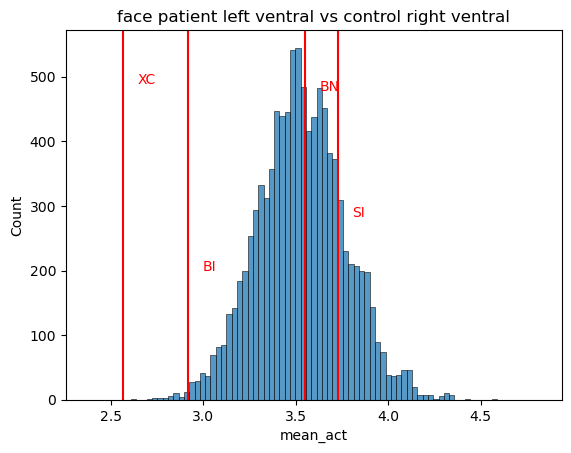

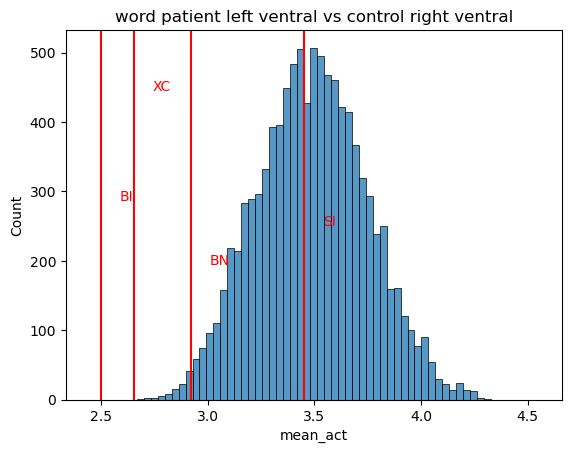

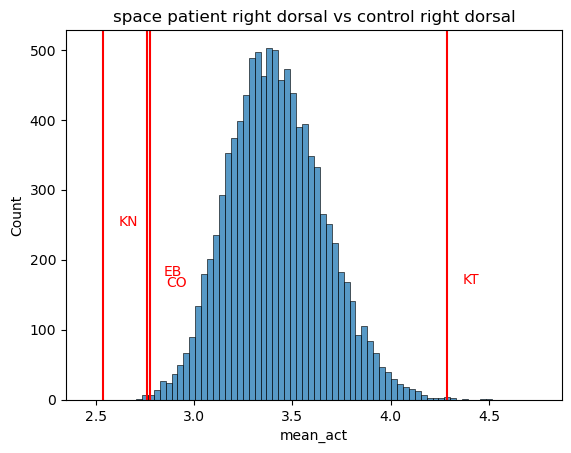

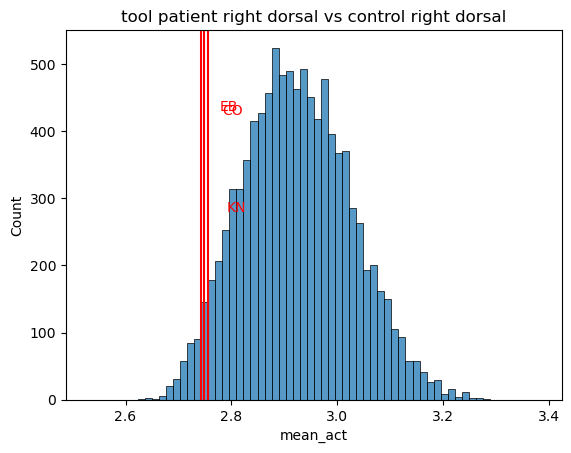

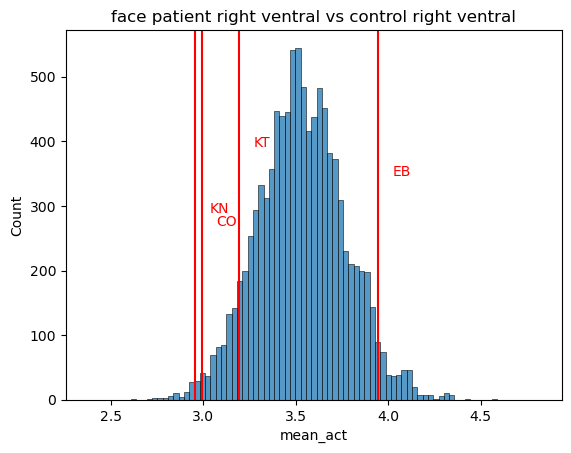

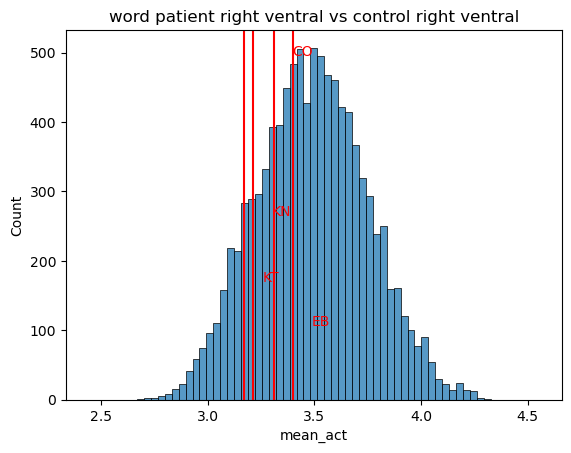

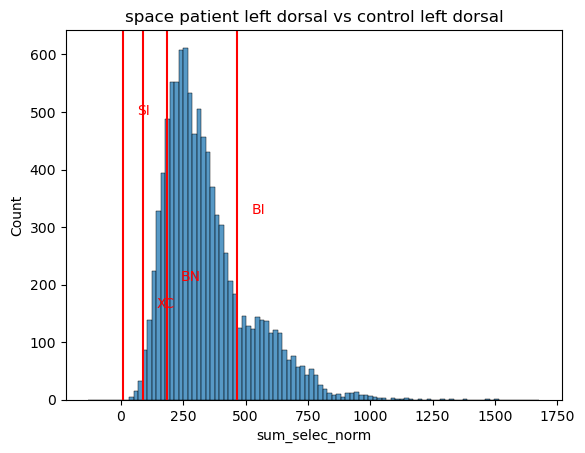

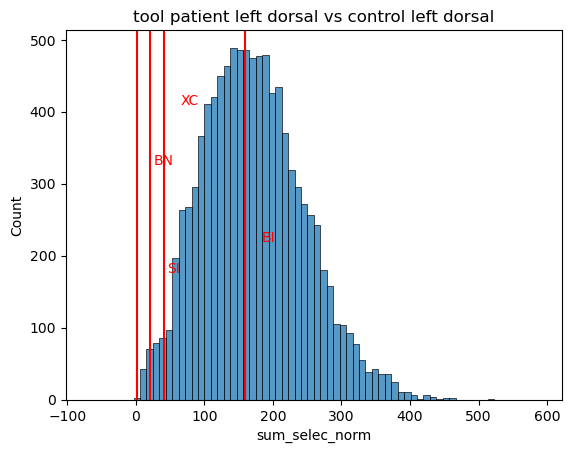

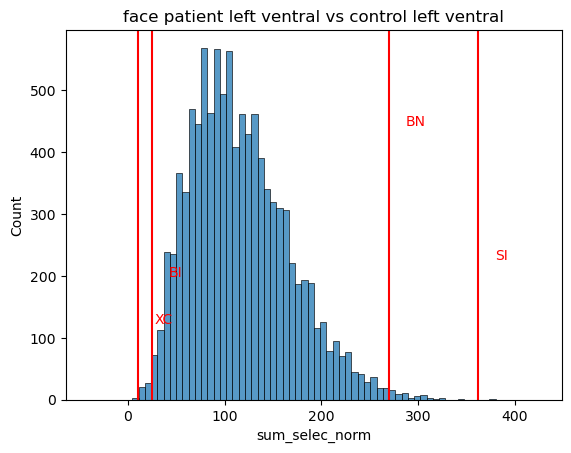

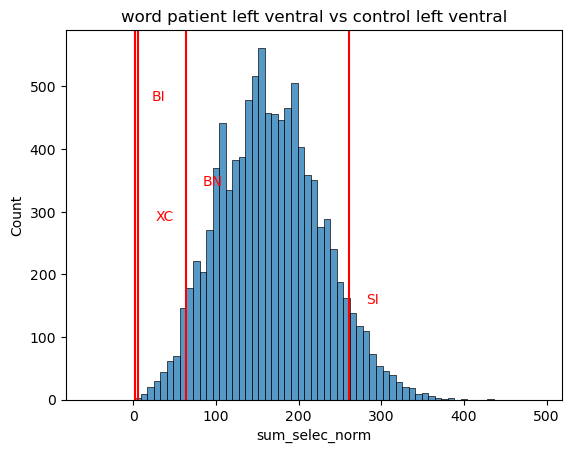

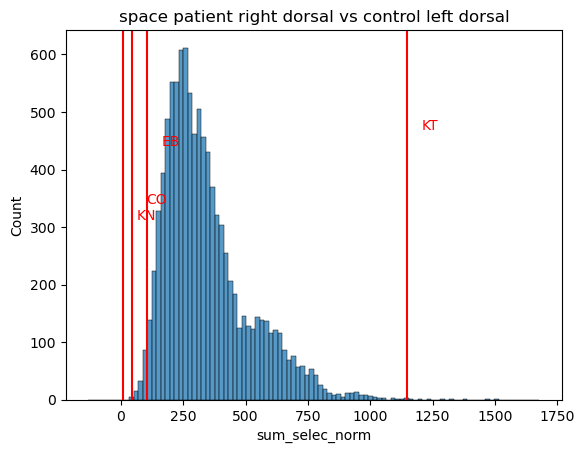

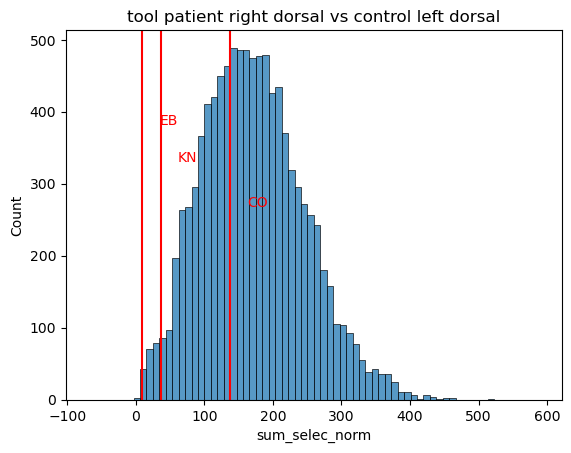

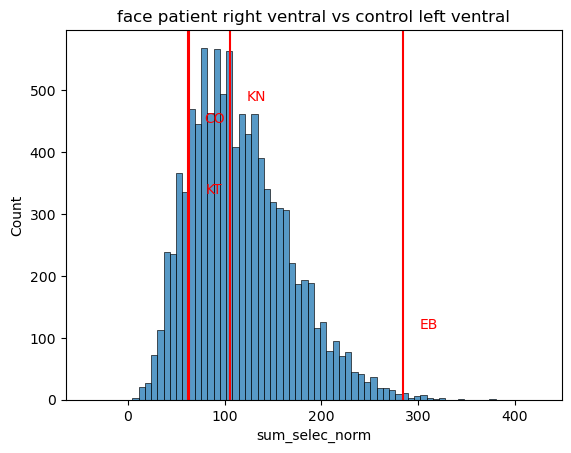

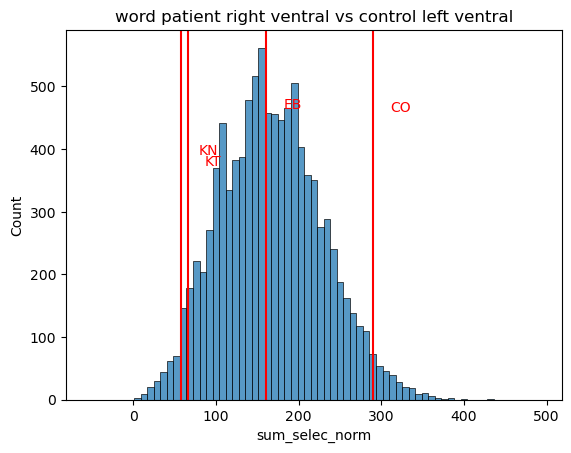

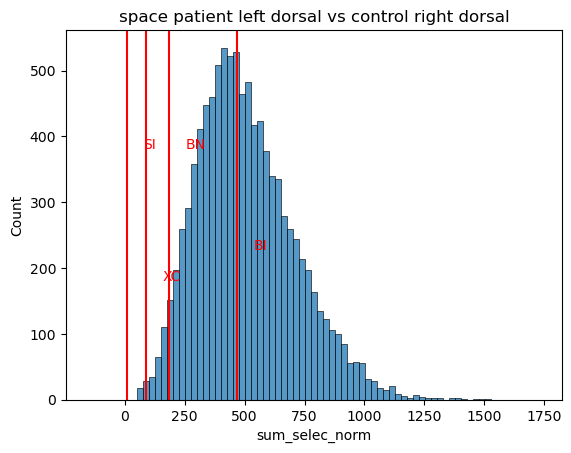

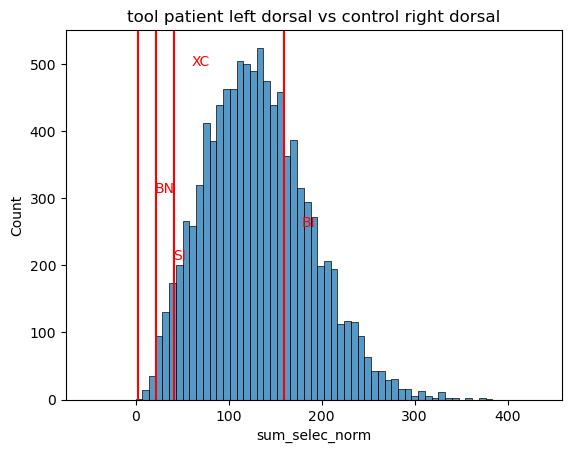

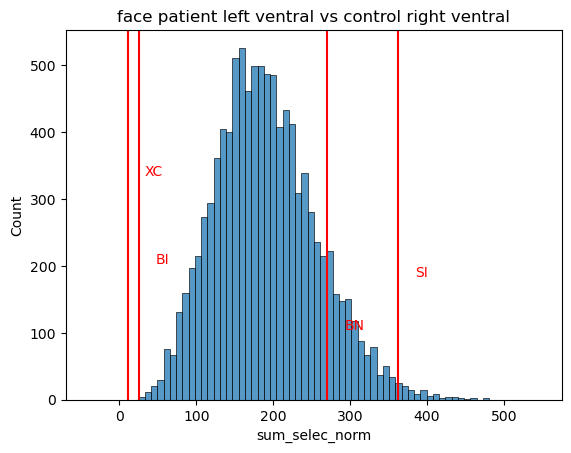

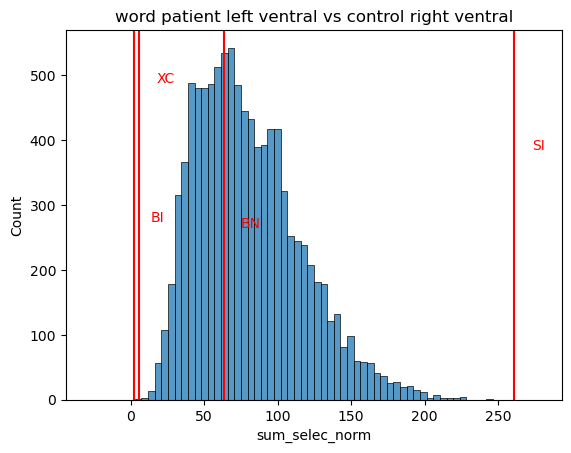

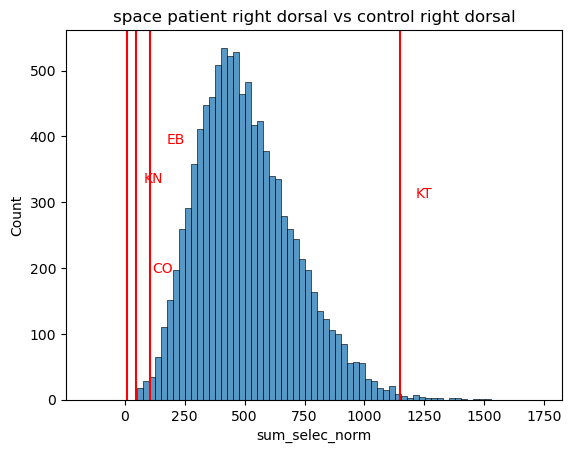

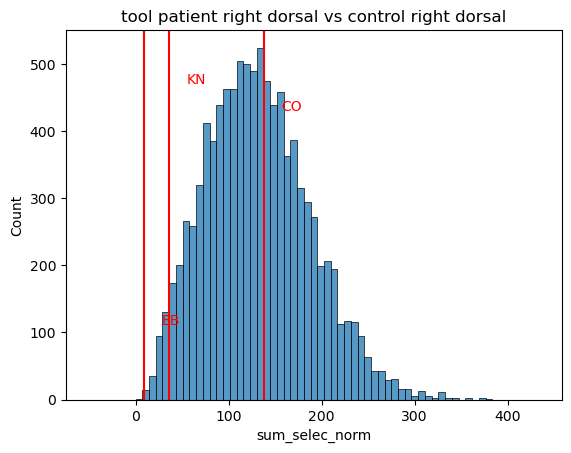

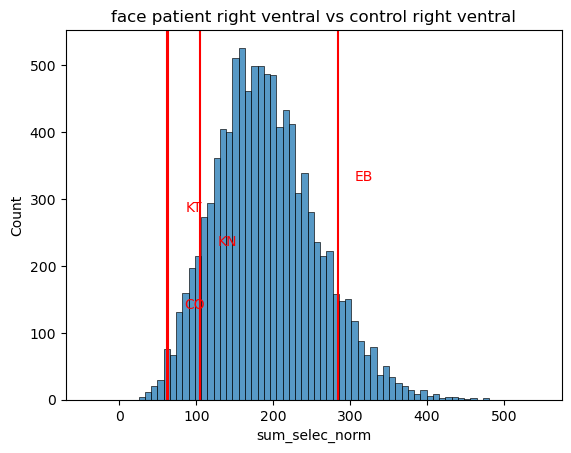

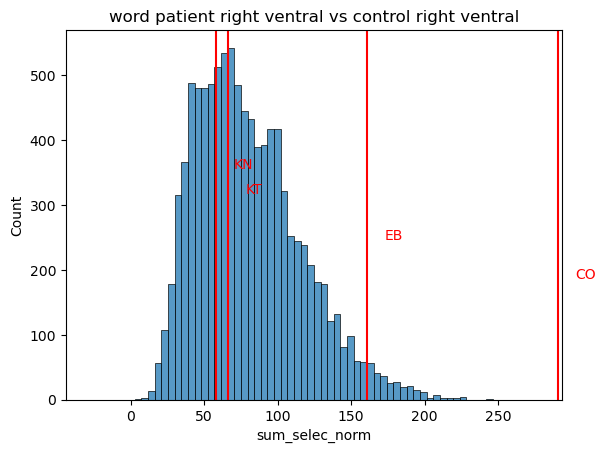

In [4]:
"""
Plot each individual patient's data on distribution of control data
"""

conds = ['space','feat', 'tool','non_tool', 'object','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'dorsal_visual_cortex', 'dorsal_visual_cortex', 
'ventral_visual_cortex', 'ventral_visual_cortex','ventral_visual_cortex']

conds = ['space', 'tool','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'ventral_visual_cortex', 'ventral_visual_cortex']

summary_val = ['mean_act', 'sum_selec_norm']
for val in summary_val:
    act_resamples = pd.read_csv(f'{results_dir}/{val}_resamples{suf}.csv')
    for control_hemi in hemis:

        for patient_hemi in hemis:
            for cond, roi in zip(conds, rois):
                control_col = f'{cond}_{control_hemi}_{roi}'

                control_data = act_resamples[control_col]
                
                #extract patient data from summary
                patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == patient_hemi) & (data_summary['roi'] == roi)][['sub',val]]
                #sub_names = patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)]
                roi_name = roi.split('_')[0]
                title = f'{cond} patient {patient_hemi} {roi_name} vs control {control_hemi} {roi_name}'
                create_histplot(control_data, patient_data,'patient',val, title)
                plt.pause(.001)




space dorsal_visual_cortex
tool dorsal_visual_cortex
face ventral_visual_cortex
word ventral_visual_cortex
space dorsal_visual_cortex
tool dorsal_visual_cortex
face ventral_visual_cortex
word ventral_visual_cortex


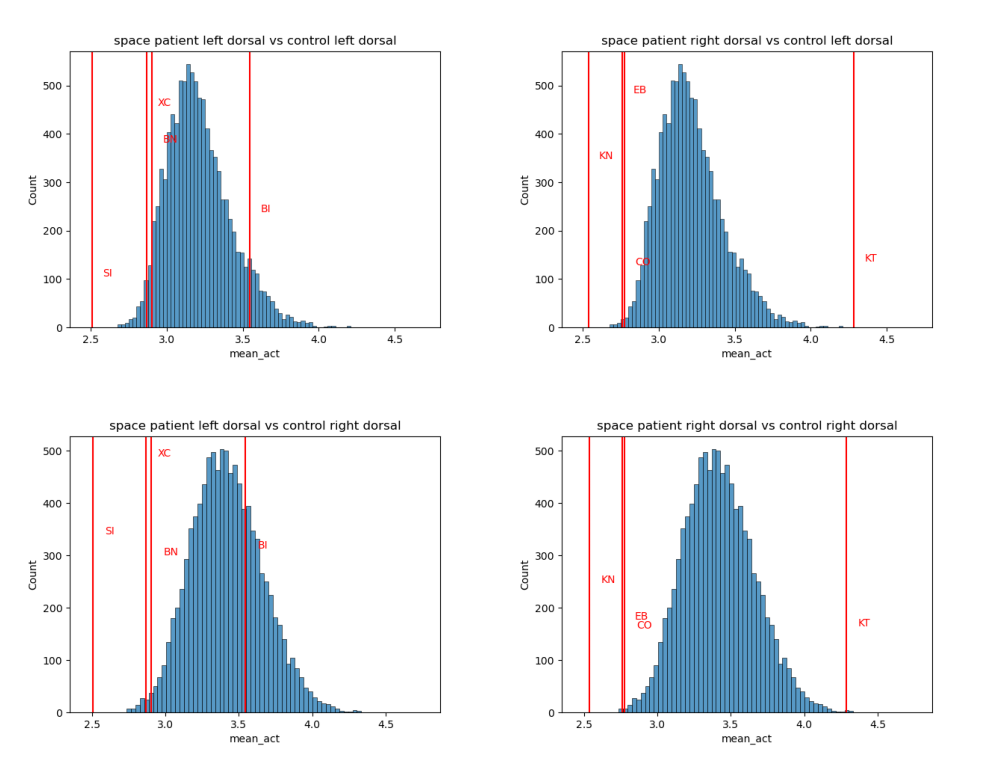

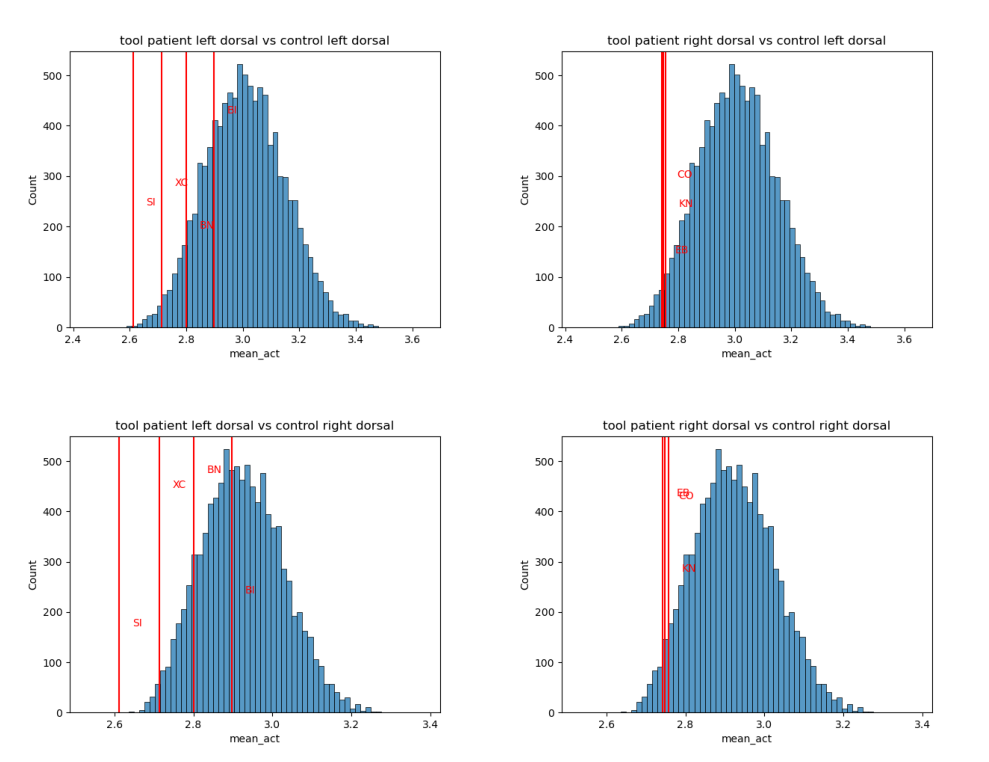

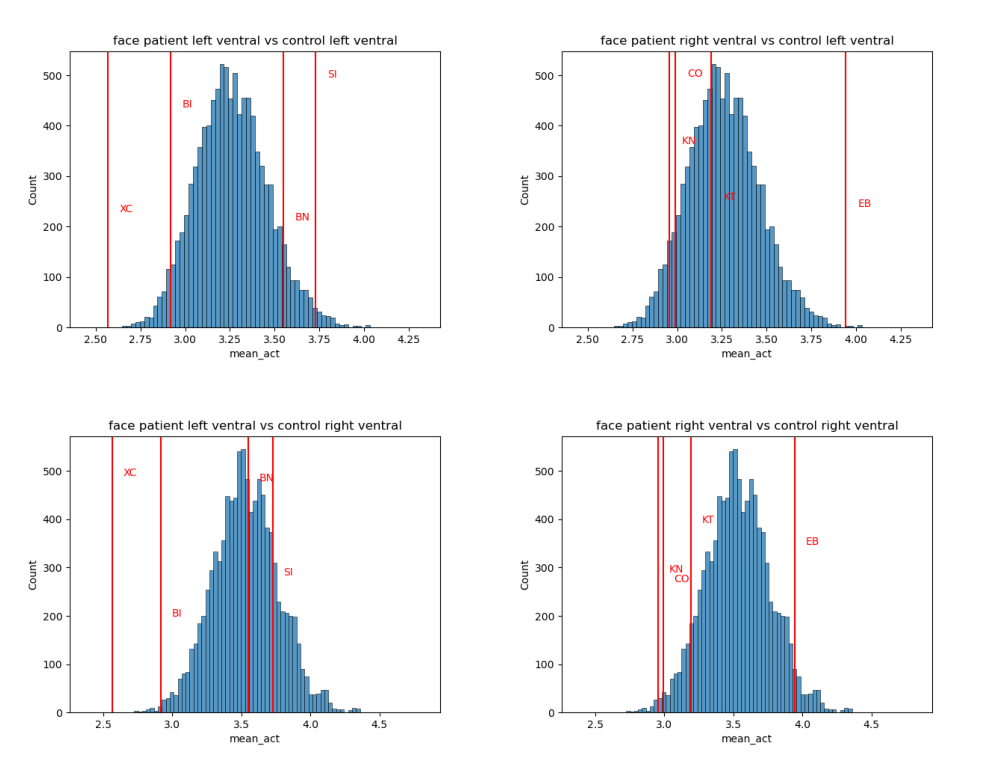

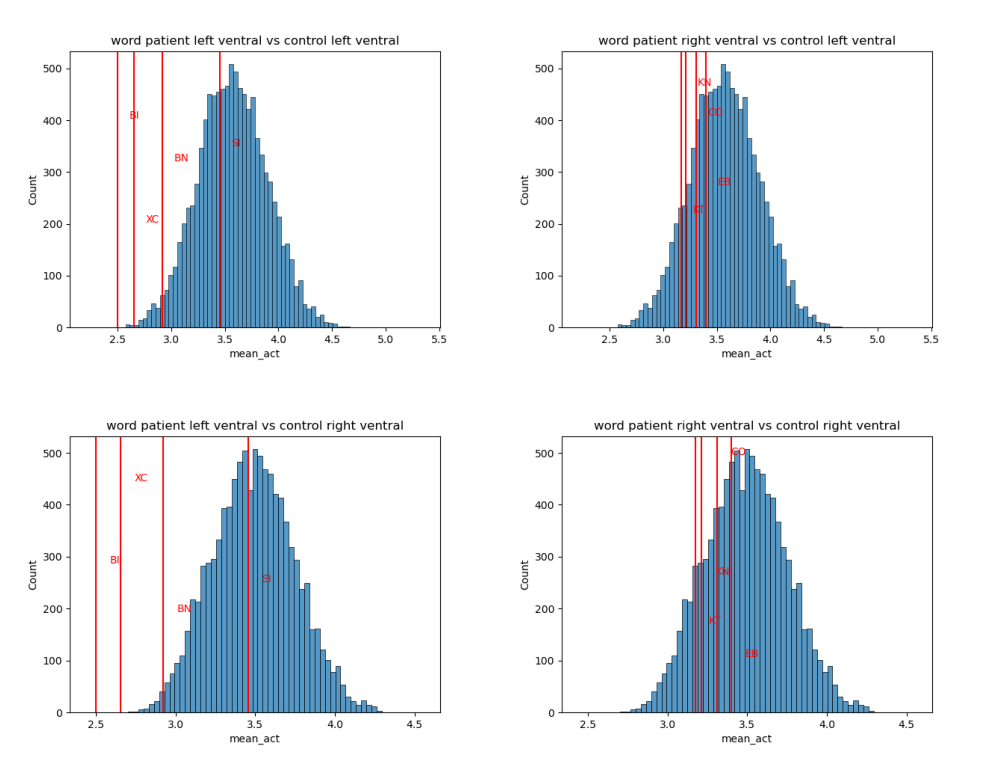

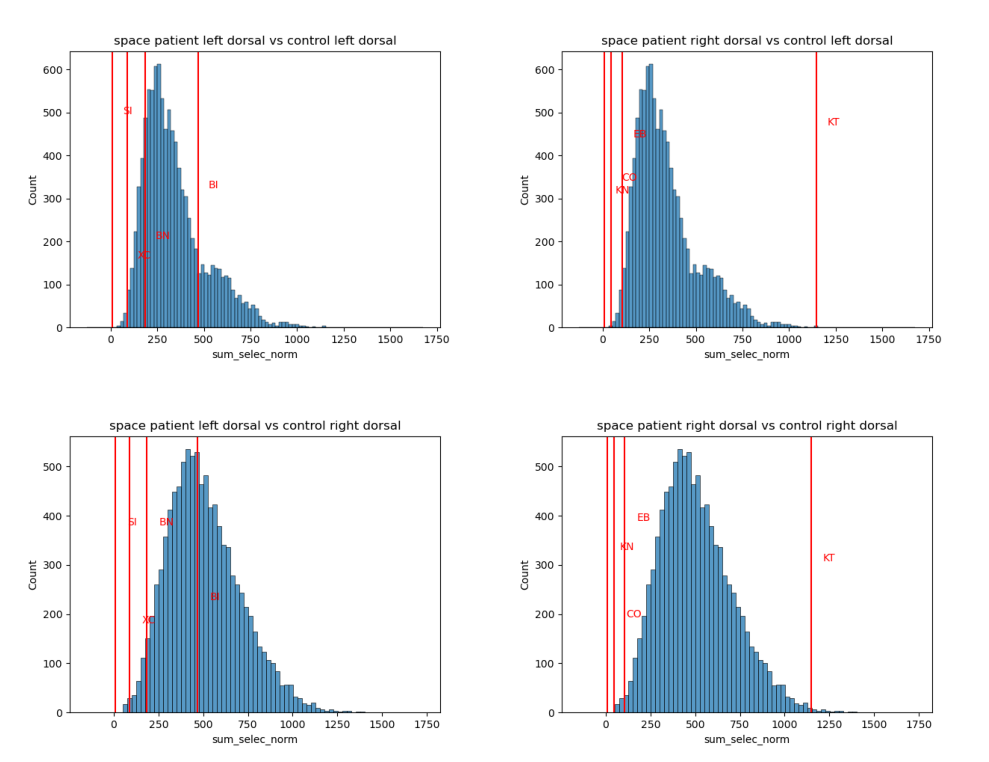

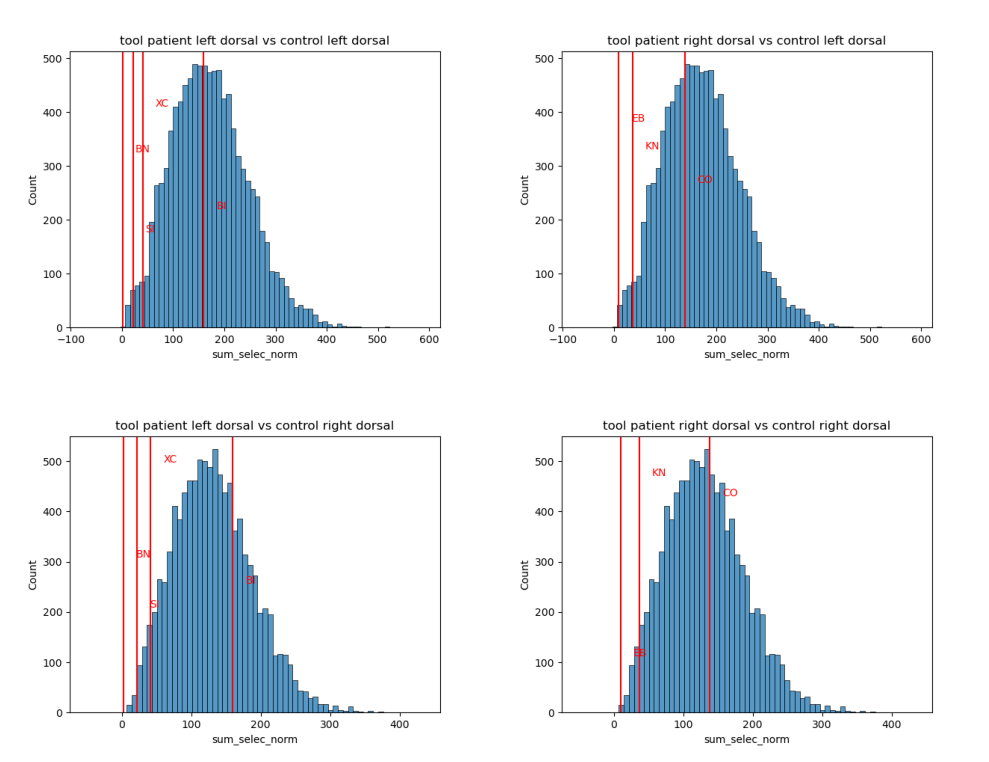

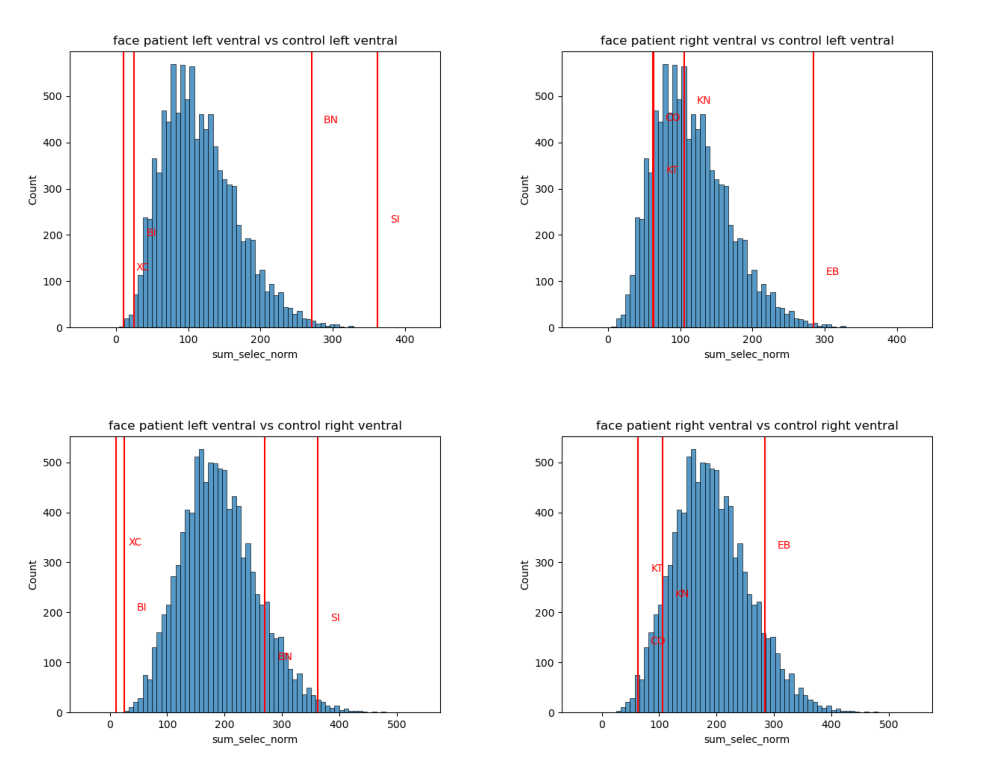

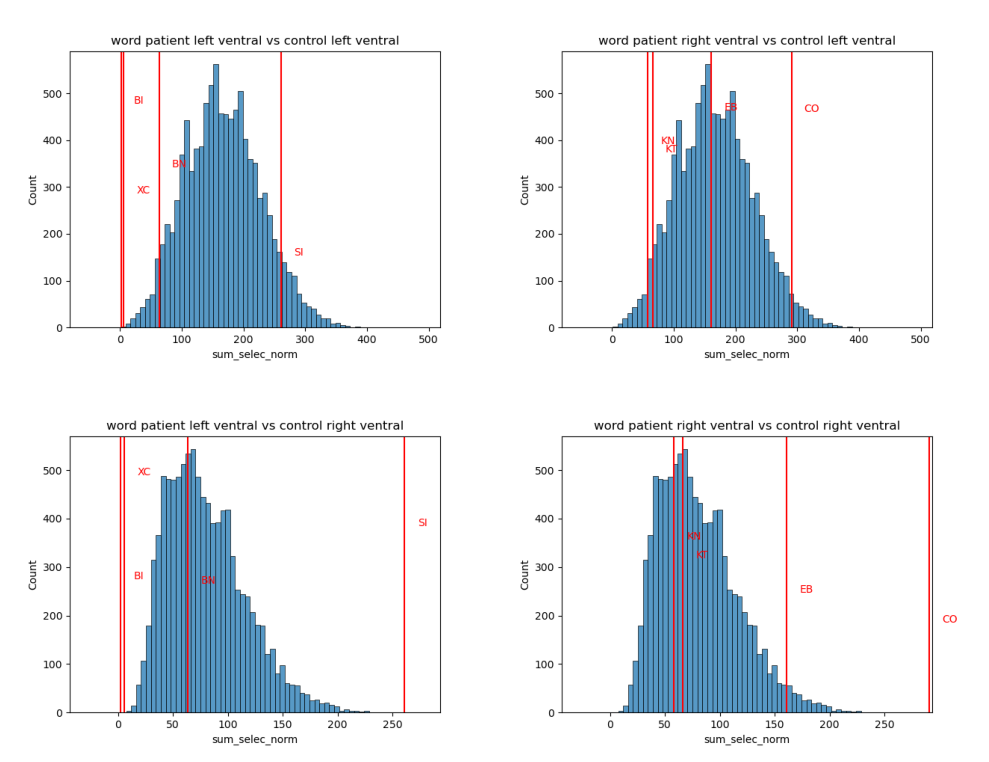

In [5]:
"""
Load each fig image and arrange in 2x2 subplot
"""


conds = ['space','feat', 'tool','non_tool', 'object','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'dorsal_visual_cortex', 'dorsal_visual_cortex', 
'ventral_visual_cortex', 'ventral_visual_cortex','ventral_visual_cortex']

conds = ['space', 'tool','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'ventral_visual_cortex', 'ventral_visual_cortex']

summary_val = ['mean_act', 'sum_selec_norm']
for val in summary_val:
    #act_resamples = pd.read_csv(f'{results_dir}/{val}_resamples{suf}.csv')
    for cond, roi in zip(conds, rois):
        print(cond,roi)
        fig, axs = plt.subplots(2,2, figsize = (10,8))
        fig.patch.set_visible(False)
        for patient_hemi in hemis:
            for control_hemi in hemis:
                roi_name = roi.split('_')[0]
                file_name = f'{val}_{cond}_patient_{patient_hemi}_{roi_name}_vs_control_{control_hemi}_{roi_name}{suf}'
                img = mpimg.imread(f'{fig_dir}/hist/indiv/{file_name}.png')
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].imshow(img)

                
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].spines['top'].set_visible(False)
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].spines['right'].set_visible(False)
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].spines['bottom'].set_visible(False)
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].spines['left'].set_visible(False)

                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].get_xaxis().set_ticks([])
                axs[hemis.index(control_hemi),hemis.index(patient_hemi)].get_yaxis().set_ticks([])
                
            
        plt.tight_layout()
        #save figure
        plt.savefig(f'{fig_dir}/hist/{val}_{cond}_{roi}{suf}.jpg')



                


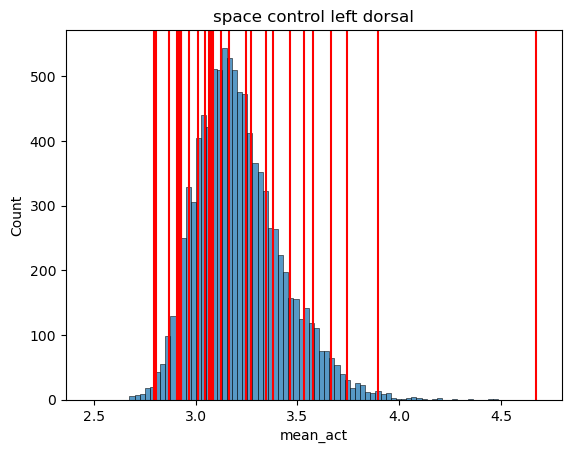

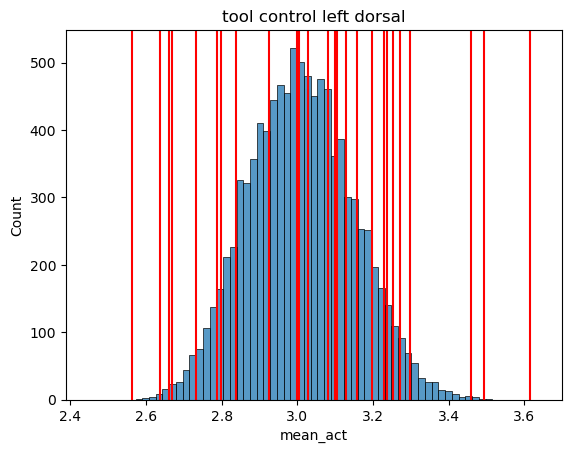

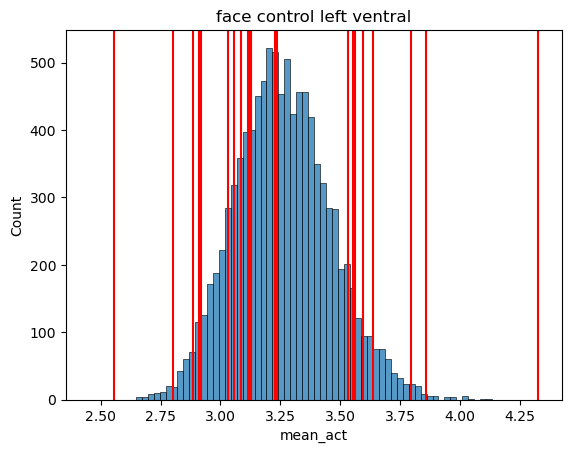

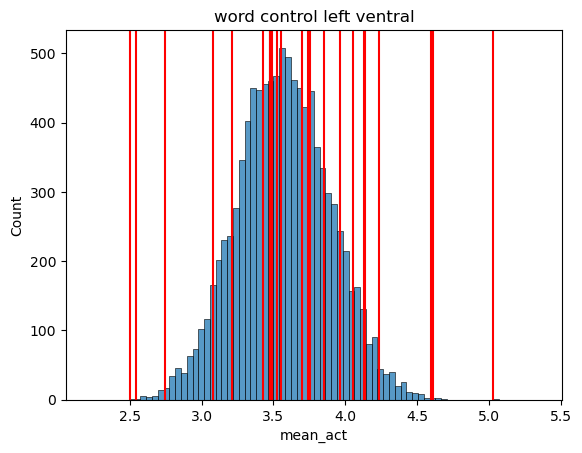

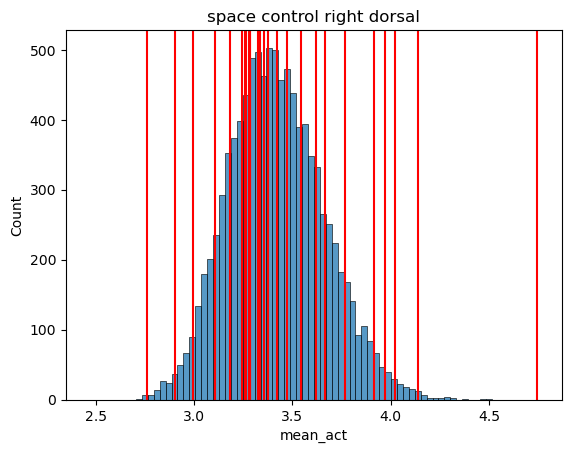

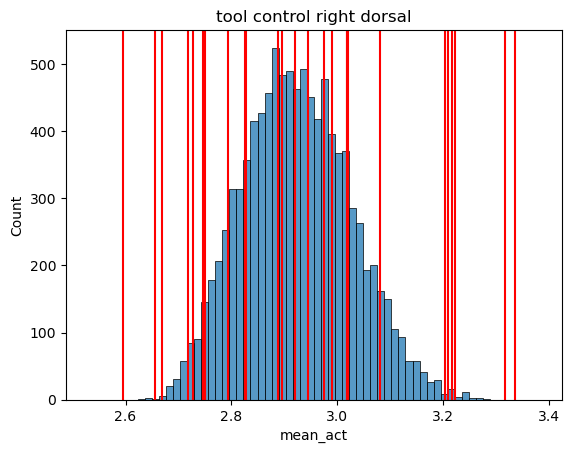

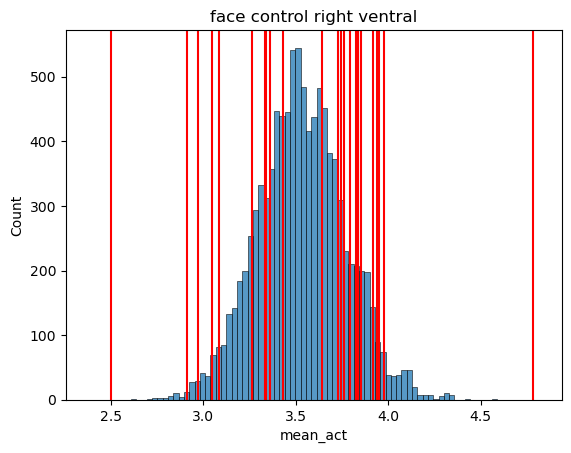

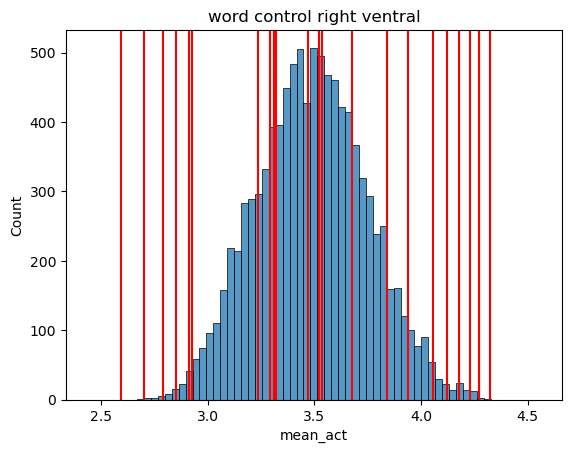

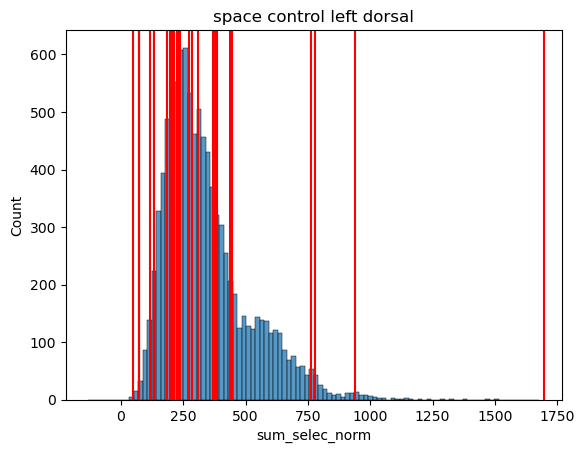

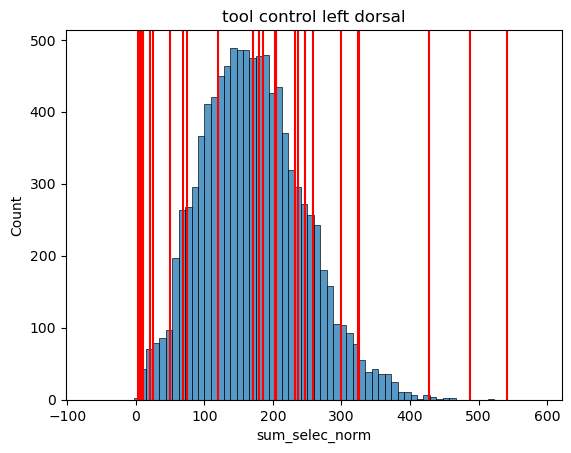

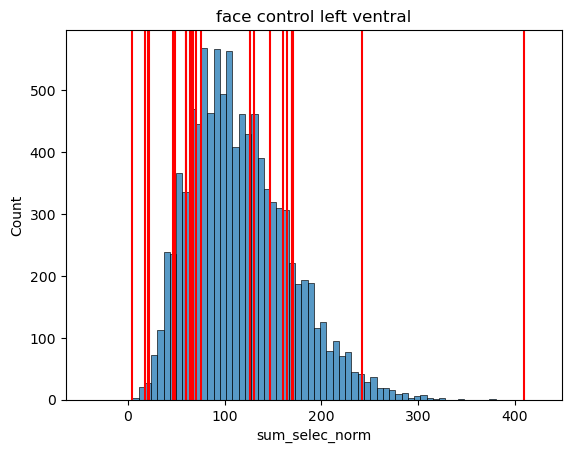

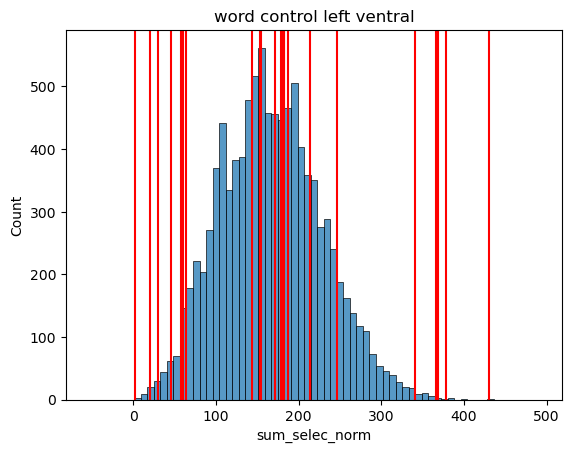

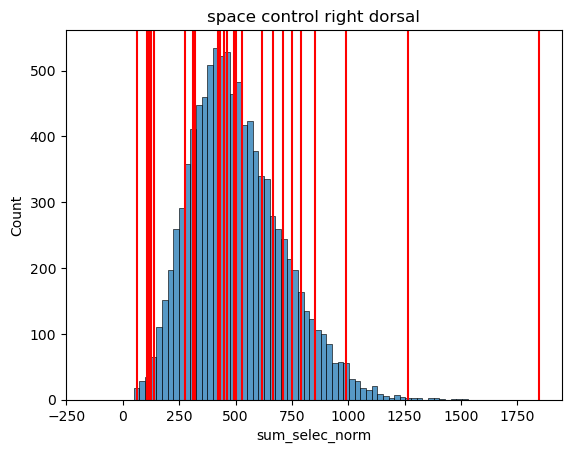

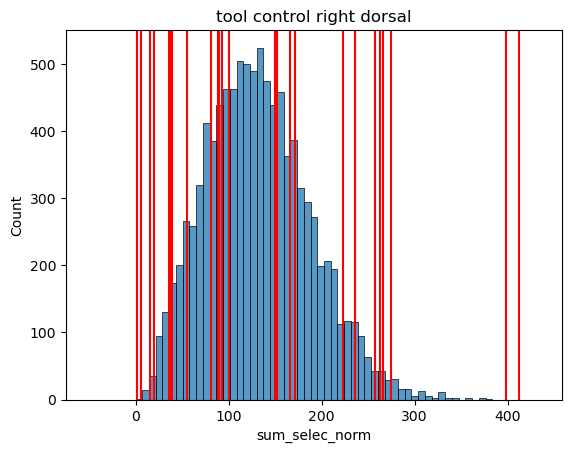

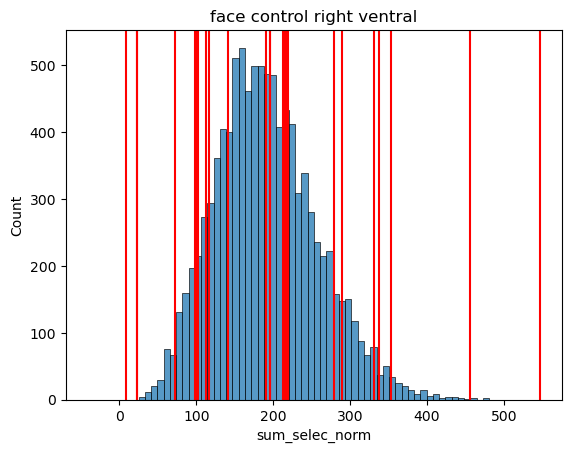

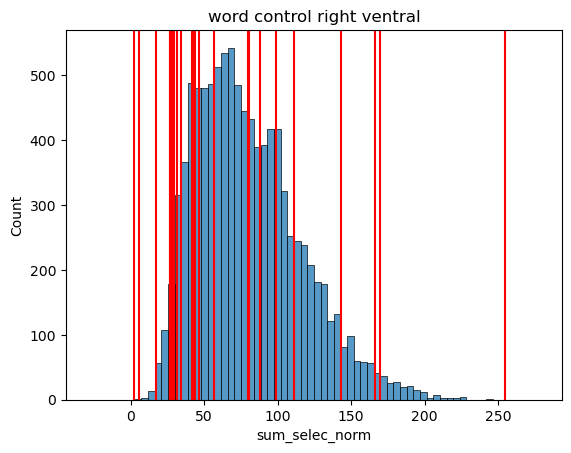

In [6]:
'''
Plot controls on distribution
'''


conds = ['space','feat', 'tool','non_tool', 'object','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'dorsal_visual_cortex', 'dorsal_visual_cortex', 
'ventral_visual_cortex', 'ventral_visual_cortex','ventral_visual_cortex']

conds = ['space', 'tool','face', 'word']
rois = ['dorsal_visual_cortex','dorsal_visual_cortex',
'ventral_visual_cortex', 'ventral_visual_cortex']

summary_val = ['mean_act', 'sum_selec_norm']
for val in summary_val:
    act_resamples = pd.read_csv(f'{results_dir}/{val}_resamples{suf}.csv')
    for control_hemi in hemis:

        for cond, roi in zip(conds, rois):
            control_col = f'{cond}_{control_hemi}_{roi}'

            control_boots = act_resamples[control_col]
            
            #extract patient data from summary
            control_data = data_summary[(data_summary['group'] == 'control') & (data_summary['cond'] == cond) & (data_summary['hemi'] == control_hemi) & (data_summary['roi'] == roi)][['sub',val]]
            #sub_names = patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)]
            roi_name = roi.split('_')[0]
            title = f'{cond} control {control_hemi} {roi_name}'
            create_histplot(control_boots, control_data,'control',val, title)
            plt.pause(.001)




In [ ]:


control_conds = ['space_left_dorsal_visual_cortex', 'tool_right_dorsal_visual_cortex',
       'face_left_ventral_visual_cortex','word_right_ventral_visual_cortex'] + ['space_right_dorsal_visual_cortex', 'tool_left_dorsal_visual_cortex',
       'face_right_ventral_visual_cortex','word_left_ventral_visual_cortex'] 

patient_conds = ['space_left_dorsal', 'tool_right_dorsal',
         'face_left_ventral','word_right_ventral'] + ['space_right_dorsal', 'tool_left_dorsal',
         'face_right_ventral','word_left_ventral']

summary_val = 'mean_act'

#load act resamples
act_resamples = pd.read_csv(f'{results_dir}/{summary_val}_resamples.csv')
for cond in control_conds:
    control_data = act_resamples[cond]
    
    #split patient conds
    cond, hemi, roi = patient_conds[control_conds.index(cond)].split('_') 
    roi = roi + '_visual_cortex'
    
    #extract patient data from summary
    patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)][['sub',summary_val]]
    #sub_names = patient_data = data_summary[(data_summary['group'] == 'patient') & (data_summary['cond'] == cond) & (data_summary['hemi'] == hemi) & (data_summary['roi'] == roi)]

    
    create_histplot(control_data, patient_data,summary_val, cond)
    plt.pause(.001)




In [ ]:
patient_data

In [ ]:
cond, hemi, roi

In [ ]:
patient_data